# Stock Data Collection Module

This notebook contains the `StockData` class for downloading, processing, and analyzing stock market data. It provides functionality to:

- Downloads historical stock data from Yahoo Finance
- Process and clean the data (handle missing values, calculate returns)
- Visualize stock prices and returns
- Save and load data locally to avoid redundant downloads

## Dependencies

In [7]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import os
import logging
import warnings

# Suppress specific pandas warning
warnings.filterwarnings('ignore', category=FutureWarning, module='pandas')

# Set up logging
logging.basicConfig(level = logging.INFO, format = '%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger('stock_data')

## StockData Class

The `StockData` class is designed to simplify the process of working with stock market data.

In [ ]:
class StockData:
    """Class to download, process, and store stock data."""
    
    def __init__(self, tickers, start_date, end_date=None, data_dir='data'):
        """
        Initialize StockData object.
        
        Parameters:
        tickers : list or str
            List of stock tickers or a single ticker string
        start_date : str
            Start date in 'YYYY-MM-DD' format
        end_date : str, optional
            End date in 'YYYY-MM-DD' format. Defaults to current date.
        data_dir : str, optional
            Directory to save downloaded data
        """
        import os
        from datetime import datetime
        
        self.tickers = [tickers] if isinstance(tickers, str) else tickers
        self.start_date = start_date
        self.end_date = end_date if end_date else datetime.now().strftime('%Y-%m-%d')
        self.data_dir = data_dir
        self.stock_data = {}
        
        # Create data directory if it doesn't exist
        if not os.path.exists(data_dir):
            os.makedirs(data_dir)
    
    def download_data(self, force_download=False):
        """
        Download historical stock data for the specified tickers.
        
        Parameters:
        force_download : bool, optional
            If True, download data even if it exists locally
            
        Returns:
        dict
            Dictionary containing DataFrames with stock data
        """
        import os
        import pandas as pd
        import yfinance as yf
        import logging
        
        # Set up logger if not already configured
        logger = logging.getLogger(__name__)
        if not logger.handlers:
            handler = logging.StreamHandler()
            logger.addHandler(handler)
            logger.setLevel(logging.INFO)
        
        for ticker in self.tickers:
            file_path = os.path.join(self.data_dir, f"{ticker}_{self.start_date}_{self.end_date}.csv")
            
            # Check if data exists locally and load if it does
            if os.path.exists(file_path) and not force_download:
                logger.info(f"Loading {ticker} data from local file")
                try:
                    df = pd.read_csv(file_path, index_col=0, parse_dates=True)
                    
                    # Convert numeric columns to float
                    for col in df.columns:
                        if col in ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']:
                            try:
                                df[col] = pd.to_numeric(df[col], errors='coerce')
                            except TypeError:
                                logger.warning(f"Could not convert column {col} to numeric for {ticker}")
                except Exception as e:
                    logger.error(f"Error loading data for {ticker}: {str(e)}")
                    continue
            else:
                logger.info(f"Downloading {ticker} data from Yahoo Finance")
                try:
                    # Explicitly set auto_adjust to False to get Adj Close column
                    df = yf.download(ticker, start=self.start_date, end=self.end_date, 
                                     auto_adjust=False, progress=False)
                    # Save data locally
                    df.to_csv(file_path)
                except Exception as e:
                    logger.error(f"Error downloading data for {ticker}: {str(e)}")
                    continue
            
            if len(df) == 0:
                logger.warning(f"No data found for {ticker}")
                continue
            
            # Ensure DataFrame has required columns
            required_cols = ['Open', 'High', 'Low', 'Close']
            missing_cols = [col for col in required_cols if col not in df.columns]
            if missing_cols:
                logger.warning(f"Missing required columns {missing_cols} for {ticker}")
                if 'Close' not in df.columns:
                    logger.error(f"Missing critical 'Close' column for {ticker}")
                    continue
            
            # Make sure price columns are numeric
            for col in ['Open', 'High', 'Low', 'Close', 'Adj Close']:
                if col in df.columns:
                    try:
                        df[col] = pd.to_numeric(df[col], errors='coerce')
                    except Exception as e:
                        logger.warning(f"Error converting {col} to numeric: {str(e)}")
            
            self.stock_data[ticker] = df
        
        return self.stock_data
    
    def preprocess_data(self):
        """
        Preprocess stock data: calculate returns and handle missing values.
        
        Returns: Dictionary containing processed DataFrames with stock data
        """
        import pandas as pd
        import numpy as np
        import logging
        
        # Set up logger if not already configured
        logger = logging.getLogger(__name__)
        if not logger.handlers:
            handler = logging.StreamHandler()
            logger.addHandler(handler)
            logger.setLevel(logging.INFO)
        
        for ticker, df in self.stock_data.items():
            logger.info(f"Preprocessing data for {ticker}")
            
            # Check for missing values
            missing_values = df.isnull().sum().sum()
            if missing_values > 0:
                logger.warning(f"Found {missing_values} missing values in {ticker} data")
                # Forward fill missing values
                df = df.ffill()
                # Backward fill any remaining NaNs (eg., at the beginning)
                df = df.bfill()
            
            # Check if 'Adj Close' column exists, otherwise use 'Close'
            price_col = 'Adj Close' if 'Adj Close' in df.columns else 'Close'
            
            # Ensure price data is numeric
            try:
                if not pd.api.types.is_numeric_dtype(df[price_col]):
                    logger.warning(f"Converting {price_col} column to numeric for {ticker}")
                    # Check if the column exists and is actually a Series before conversion
                    if price_col in df.columns and isinstance(df[price_col], pd.Series):
                        df[price_col] = pd.to_numeric(df[price_col], errors='coerce')
                    else:
                        logger.error(f"Column {price_col} is not a valid Series for {ticker}")
            except Exception as e:
                logger.error(f"Error ensuring {price_col} is numeric: {str(e)}")
                # Fallback to Close if Adj Close has issues
                if price_col == 'Adj Close' and 'Close' in df.columns:
                    price_col = 'Close'
                    logger.warning(f"Falling back to 'Close' column for {ticker}")
                    # Check if the column exists and is actually a Series before conversion
                    if price_col in df.columns and isinstance(df[price_col], pd.Series):
                        df[price_col] = pd.to_numeric(df[price_col], errors='coerce')
                    else:
                        logger.error(f"Column {price_col} is not a valid Series for {ticker}")
            
            # Calculate daily returns
            try:
                df['Daily_Return'] = df[price_col].pct_change()
            except Exception as e:
                logger.error(f"Error calculating daily returns: {str(e)}")
                df['Daily_Return'] = 0
            
            # Calculate log returns - ensure no zeros or negative values in price data
            try:
                valid_prices = (df[price_col] > 0)
                if valid_prices.all():
                    df['Log_Return'] = np.log(df[price_col] / df[price_col].shift(1))
                else:
                    logger.warning(f"Found non-positive values in {ticker} price data. Using pct_change for log returns.")
                    df['Log_Return'] = np.log1p(df['Daily_Return'])
            except Exception as e:
                logger.error(f"Error calculating log returns: {str(e)}")
                df['Log_Return'] = 0
            
            # Calculate cumulative returns
            try:
                df['Cumulative_Return'] = (1 + df['Daily_Return']).cumprod() - 1
            except Exception as e:
                logger.error(f"Error calculating cumulative returns: {str(e)}")
                df['Cumulative_Return'] = 0
            
            # Clean up possible remaining NaNs
            df = df.dropna()
            
            self.stock_data[ticker] = df
        
        return self.stock_data
    
    def plot_prices(self, tickers=None):
        """
        Plot adjusted close prices for specified tickers.
        
        Parameters:
        tickers : list or str, optional
            List of tickers to plot or a single ticker.
            If None, plot all tickers.
        """
        
        if tickers is None:
            tickers = self.tickers
        elif isinstance(tickers, str):
            tickers = [tickers]
        
        plt.figure(figsize=(12, 6))

        for ticker in tickers:
            if ticker in self.stock_data:
                price_col = 'Adj Close' if 'Adj Close' in self.stock_data[ticker].columns else 'Close'
                prices = self.stock_data[ticker][price_col]
                plt.plot(prices.index, prices.values, label=ticker)

        # Show every 80th date on x-axis 
        # to avoid cluttering
        sample_ticker = tickers[0]
        if sample_ticker in self.stock_data:
            dates = self.stock_data[sample_ticker].index
            step = 80
            xticks = dates[::step]
            plt.xticks(ticks=xticks, labels=[date for date in xticks], rotation=45)

        plt.title('Stock Prices')
        plt.xlabel('Date')
        plt.ylabel('Price ($)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    
    def plot_returns(self, tickers=None):
        """
        Plot cumulative returns for specified tickers.
        
        Parameters:
        tickers : list or str, optional
            List of tickers to plot or a single ticker.
            If None, plot all tickers.
        """
        
        if tickers is None:
            tickers = self.tickers
        elif isinstance(tickers, str):
            tickers = [tickers]
        
        plt.figure(figsize=(12, 6))
        
        for ticker in tickers:
            if ticker in self.stock_data:
                plt.plot(self.stock_data[ticker]['Cumulative_Return'], label=ticker)
        

        # Show every 80th date on x-axis 
        # to avoid cluttering
        sample_ticker = tickers[0]
        if sample_ticker in self.stock_data:
            dates = self.stock_data[sample_ticker].index
            step = 80
            xticks = dates[::step]
            plt.xticks(ticks=xticks, labels=[date for date in xticks], rotation=45)
        
        plt.title('Cumulative Returns')
        plt.xlabel('Date')
        plt.ylabel('Return (%)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    
    def get_data(self, ticker=None):
        """
        Get processed data for a specific ticker or all tickers.
        
        Parameters:
        ticker : str, optional
            Ticker to get data for. If None, return data for all tickers.
            
        Returns:
        DataFrame or dict
            DataFrame with stock data for a specific ticker or 
            dictionary of DataFrames for all tickers
        """
        if ticker is not None:
            if ticker in self.stock_data:
                return self.stock_data[ticker]
            else:
                import logging
                logger = logging.getLogger(__name__)
                logger.warning(f"No data found for {ticker}")
                return None
        else:
            return self.stock_data

## Example Usage

How to use the `StockData` class with an example:

In [66]:
# Get data for multiple stocks from the last 2 years
tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOG']
start_date = (datetime.now() - timedelta(days=2*365)).strftime('%Y-%m-%d')
end_date = datetime.now().strftime('%Y-%m-%d')

# Create StockData object and download data
stock_data = StockData(tickers, start_date, end_date)
stock_data.download_data()
stock_data.preprocess_data()

Loading AAPL data from local file
2025-05-13 13:19:54,663 - __main__ - INFO - Loading AAPL data from local file
C:\Users\HP\AppData\Local\Temp\ipykernel_10428\1252152011.py:64: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(file_path, index_col=0, parse_dates=True)
Loading MSFT data from local file
2025-05-13 13:19:54,676 - __main__ - INFO - Loading MSFT data from local file
C:\Users\HP\AppData\Local\Temp\ipykernel_10428\1252152011.py:64: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(file_path, index_col=0, parse_dates=True)
Loading AMZN data from local file
2025-05-13 13:19:54,688 - __main__ - INFO - Loading AMZN data from local file
C:\Users\HP\AppData\Local\Temp\ipykernel_104

{'AAPL':              Adj Close       Close        High         Low        Open  \
 Price                                                                    
 Date        170.587692  172.070007  173.210007  171.470001  173.160004   
 2023-05-15  170.587692  172.070007  173.210007  171.470001  173.160004   
 2023-05-16  170.587692  172.070007  173.139999  171.800003  171.990005   
 2023-05-17  171.202332  172.690002  172.929993  170.419998  171.710007   
 2023-05-18  173.542007  175.050003  175.240005  172.580002  173.000000   
 ...                ...         ...         ...         ...         ...   
 2025-05-06  198.509995  198.509995  200.649994  197.020004  198.210007   
 2025-05-07  196.250000  196.250000  199.440002  193.250000  199.169998   
 2025-05-08  197.490005  197.490005  200.050003  194.679993  197.720001   
 2025-05-09  198.529999  198.529999  200.539993  197.539993  199.000000   
 2025-05-12  210.789993  210.789993  211.266495  206.750000  210.970001   
 
               

### Visualize Stock Prices

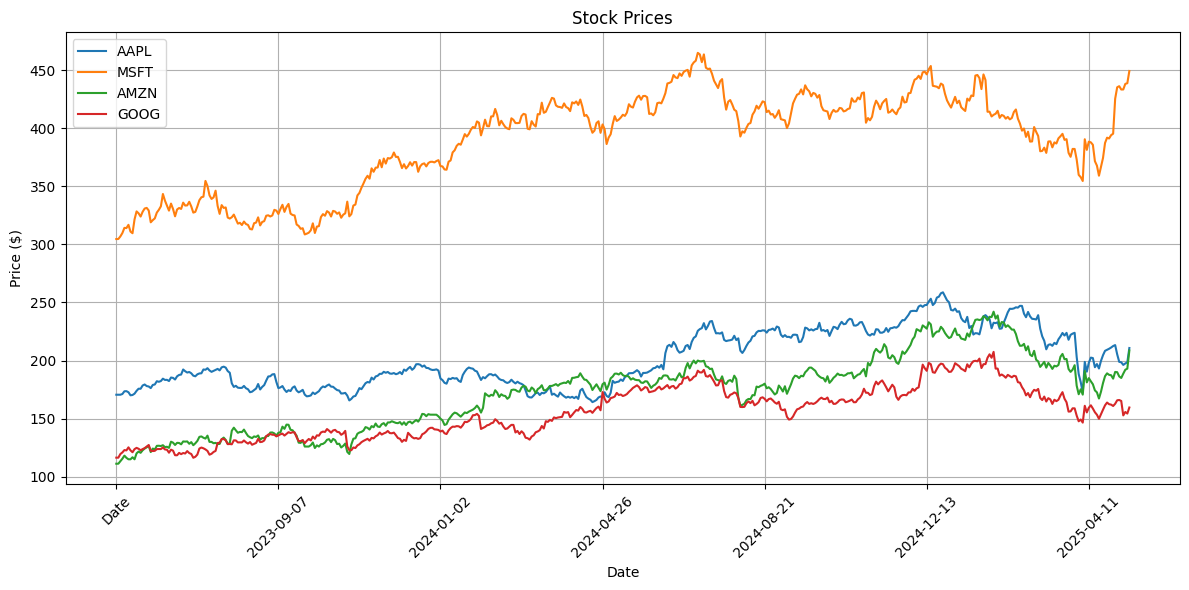

In [67]:
# Plot prices for all tickers
stock_data.plot_prices()

### Visualize Stock Returns

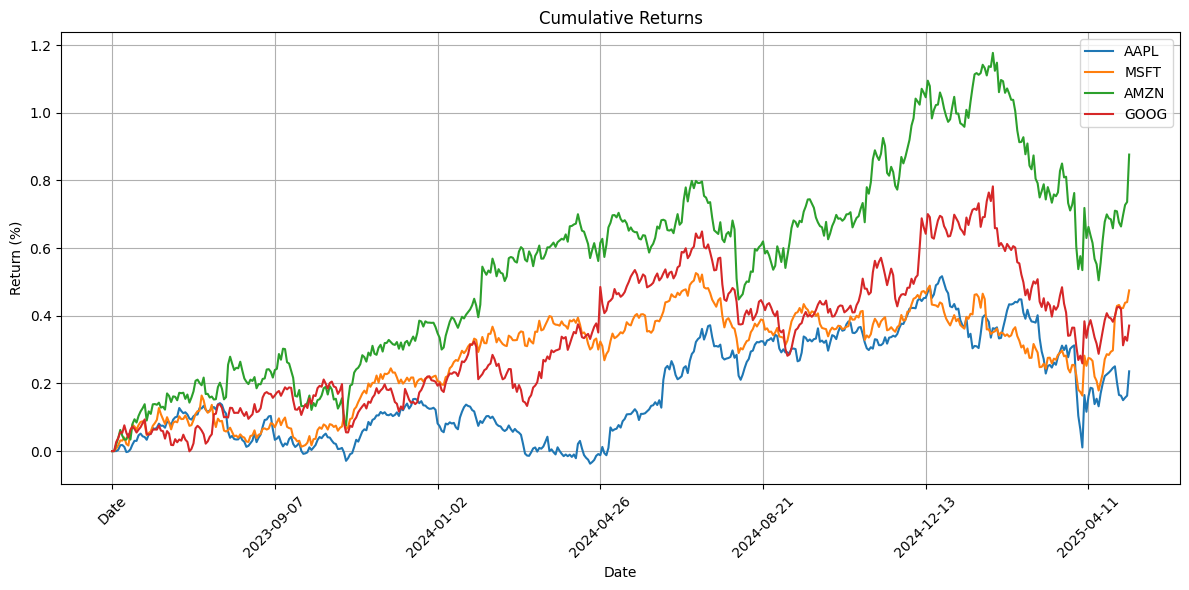

In [68]:
# Plot returns for all tickers
stock_data.plot_returns()

### Examine Data for a Specific Stock

In [69]:
# Access data for a specific ticker
aapl_data = stock_data.get_data('AAPL')
aapl_data.head()

,Adj Close,Close,High,Low,Open,Volume,Daily_Return,Log_Return,Cumulative_Return
Price,,,,,,,,,
Date,170.587692,172.070007,173.210007,171.470001,173.160004,37266700.0,0.000000,0.000000,0.000000
2023-05-15,170.587692,172.070007,173.210007,171.470001,173.160004,37266700.0,0.000000,0.000000,0.000000
2023-05-16,170.587692,172.070007,173.139999,171.800003,171.990005,42110300.0,0.000000,0.000000,0.000000
2023-05-17,171.202332,172.690002,172.929993,170.419998,171.710007,57951600.0,0.003603,0.003597,0.003603
2023-05-18,173.542007,175.050003,175.240005,172.580002,173.000000,65496700.0,0.013666,0.013574,0.017318


## Summary

This notebook provides a framework for collecting and preprocessing stock market data. The `StockData` class handles downloading data from Yahoo Finance and processes it. 

Features I have implemented:
- Proper error handling and logging
- Data caching to avoid redundant downloads
- Calculation of daily and cumulative returns
- Visualization functions for prices and returns